# Part 1: K-means Clustering Based on Average User Ratings



## 1. Library Imports and Configuration


In [1]:
# =============================================================================
# LIBRARY IMPORTS AND CONFIGURATION
# =============================================================================

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Standard library imports
import os
import sys
import warnings
from collections import defaultdict

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Dataset Loading


In [2]:
# =============================================================================
# DATASET LOADING
# =============================================================================

# Define paths (relative paths for portability)
DATASET_PATH = '../Digital_Music.csv'
RESULTS_PATH = '../../results'

# Create results directory if it doesn't exist
os.makedirs(RESULTS_PATH, exist_ok=True)

# Load Digital Music dataset
print("Loading Digital Music dataset...")
ratings = pd.read_csv(
    os.path.join(DATASET_PATH, '../Digital_Music.csv'),
    header=None,
    names=['item_id', 'user_id', 'rating', 'timestamp']
)

print(f"Ratings shape: {ratings.shape}")
print(f"Unique users: {ratings['user_id'].nunique():,}")
print(f"Unique items: {ratings['item_id'].nunique():,}")


Loading Digital Music dataset...
Ratings shape: (1584082, 4)
Unique users: 840,372
Unique items: 456,992


## 3. Calculate User Average Ratings (from Section ONE)


In [3]:
# =============================================================================
# CALCULATE USER AVERAGE RATINGS
# =============================================================================
# Task 1: Use the calculated average rating given by each user (r̄_u) from Section ONE

# Calculate average rating per user
user_avg_ratings = ratings.groupby('user_id')['rating'].mean().reset_index()
user_avg_ratings.columns = ['user_id', 'avg_rating']

# Also get number of ratings per user for reference
user_num_ratings = ratings.groupby('user_id')['rating'].count().reset_index()
user_num_ratings.columns = ['user_id', 'num_ratings']

# Merge
user_stats = pd.merge(user_avg_ratings, user_num_ratings, on='user_id')

print(f"Total users: {len(user_stats):,}")
print(f"\nUser average rating statistics:")
print(user_stats['avg_rating'].describe())

# Display sample
print("\nSample user statistics:")
display(user_stats.head(10))


Total users: 840,372

User average rating statistics:
count   840372.00
mean         4.65
std          0.86
min          1.00
25%          5.00
50%          5.00
75%          5.00
max          5.00
Name: avg_rating, dtype: float64

Sample user statistics:


,user_id,avg_rating,num_ratings
0,A00041408PB8URN3FSQ6,5.00,1
1,A0009988MRFQ3TROTQPI,5.00,2
2,A0015420M7GRKSKTW32Z,5.00,1
3,A0025284EDB2S5Q3G9PD,5.00,1
4,A002800078UB6PFVGW0Q,5.00,1
5,A0030206VG57VGEVI2K5,5.00,1
6,A00302287A5VF8R6JTUD,5.00,1
7,A0030604C4PLPAGEUSPV,5.00,1
8,A0032752LTC7FRSBF7K,5.00,1
9,A00356524ZD9ADEBGN14,5.00,1


## 4. Create Feature Vectors and Normalize


In [4]:
# =============================================================================
# CREATE FEATURE VECTORS AND NORMALIZE
# =============================================================================
# Tasks 2-5: Create 1D feature vector, calculate μ and σ, normalize using Z-score

# Extract feature vector (1D array of average ratings)
X = user_stats['avg_rating'].values.reshape(-1, 1)
user_ids = user_stats['user_id'].values

# Calculate mean (μ) and standard deviation (σ)
mu = np.mean(X)
sigma = np.std(X, ddof=0)

print(f"Feature vector shape: {X.shape}")
print(f"Mean (μ): {mu:.4f}")
print(f"Standard deviation (σ): {sigma:.4f}")

# Normalize using Z-score: z_u = (r̄_u - μ) / σ
X_normalized = (X - mu) / sigma

print(f"\nNormalized feature statistics:")
print(f"  Mean: {np.mean(X_normalized):.6f} (should be ~0)")
print(f"  Std: {np.std(X_normalized):.6f} (should be ~1)")


Feature vector shape: (840372, 1)
Mean (μ): 4.6452
Standard deviation (σ): 0.8613

Normalized feature statistics:
  Mean: 0.000000 (should be ~0)
  Std: 1.000000 (should be ~1)


## 5. Apply K-means Clustering with Different K Values


In [5]:
# =============================================================================
# K-MEANS CLUSTERING WITH DIFFERENT K VALUES
# =============================================================================
# Task 6: Apply K-means with K = 5, 10, 15, 20, 30, 50
# Note: silhouette_score on the full dataset (840k users) is O(n^2) and
# impractical. We use a subsample for silhouette to keep runtime reasonable
# while still comparing cluster quality across K.

K_values = [5, 10, 15, 20, 30, 50]
clustering_results = {}
wcss_scores = []
silhouette_scores = []

print("Running K-means clustering for different K values...")
print("=" * 60)

sil_sample_size = 10000  # adjust down if runtime is still high
sil_random_state = 42

for k in K_values:
    print(f"\nK = {k}:")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_normalized)
    
    wcss = kmeans.inertia_
    silhouette = silhouette_score(
        X_normalized,
        cluster_labels,
        sample_size=min(sil_sample_size, len(X_normalized)),
        random_state=sil_random_state
    )
    
    wcss_scores.append(wcss)
    silhouette_scores.append(silhouette)
    
    clustering_results[k] = {
        'model': kmeans,
        'labels': cluster_labels,
        'centroids': kmeans.cluster_centers_,
        'wcss': wcss,
        'silhouette': silhouette
    }
    
    print(f"  WCSS: {wcss:.2f}")
    print(f"  Silhouette Score (sampled): {silhouette:.4f}")

print("\n" + "=" * 60)
print("Clustering complete!")


Running K-means clustering for different K values...

K = 5:
  WCSS: 9869.81
  Silhouette Score (sampled): 0.9393

K = 10:
  WCSS: 557.58
  Silhouette Score (sampled): 0.9704

K = 15:
  WCSS: 158.59
  Silhouette Score (sampled): 0.9759

K = 20:
  WCSS: 67.48
  Silhouette Score (sampled): 0.9807

K = 30:
  WCSS: 18.99
  Silhouette Score (sampled): 0.9854

K = 50:
  WCSS: 4.58
  Silhouette Score (sampled): 0.9892

Clustering complete!


## 6. Plot Elbow Curve and Determine Optimal K


Clustering Results Summary:


,K,WCSS,Silhouette_Score
0,5,9869.81,0.94
1,10,557.58,0.97
2,15,158.59,0.98
3,20,67.48,0.98
4,30,18.99,0.99
5,50,4.58,0.99


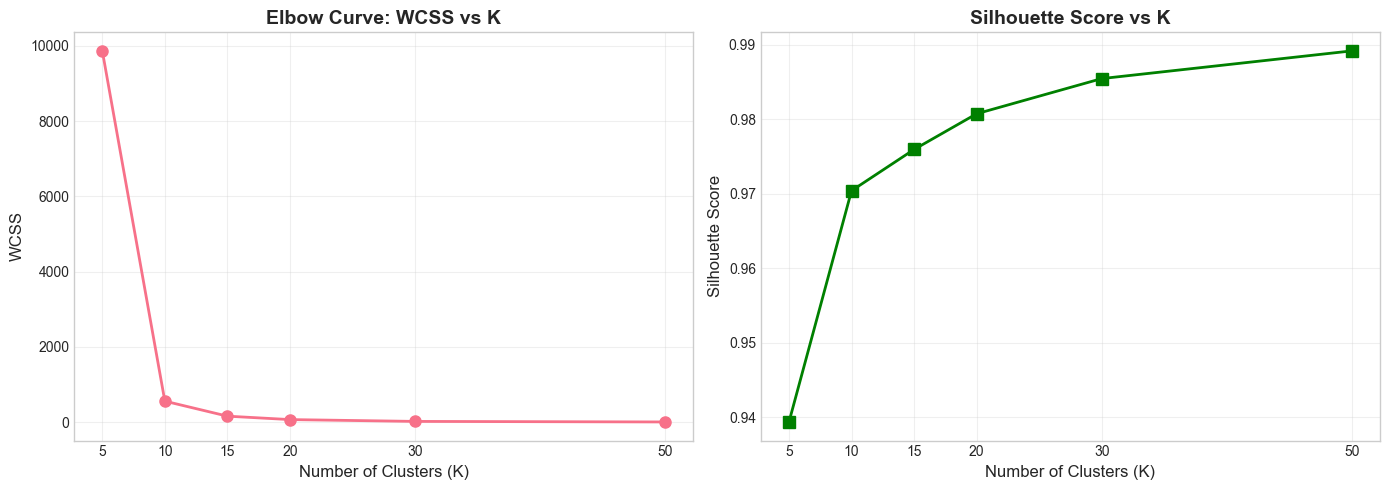


Optimal K: 50 (Silhouette Score: 0.9892)


In [6]:
# =============================================================================
# PLOT ELBOW CURVE AND DETERMINE OPTIMAL K
# =============================================================================
# Tasks 7.3, 7.4, 8: Plot elbow curve, silhouette scores, and determine optimal K

# Create summary DataFrame
results_df = pd.DataFrame({
    'K': K_values,
    'WCSS': wcss_scores,
    'Silhouette_Score': silhouette_scores
})

print("Clustering Results Summary:")
print("=" * 60)
display(results_df)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_values, wcss_scores, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('WCSS', fontsize=12)
axes[0].set_title('Elbow Curve: WCSS vs K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_values)

axes[1].plot(K_values, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_values)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'part1_elbow_silhouette.png'), dpi=300, bbox_inches='tight')
plt.show()

# Determine optimal K (based on silhouette score)
optimal_k = K_values[np.argmax(silhouette_scores)]
optimal_clustering = clustering_results[optimal_k]
optimal_labels = optimal_clustering['labels']
optimal_centroids = optimal_clustering['centroids']

print(f"\nOptimal K: {optimal_k} (Silhouette Score: {max(silhouette_scores):.4f})")


Distribution of Users Across Clusters (K = 50):
Cluster 0: 647,508 users (77.05%)
Cluster 1: 24,966 users (2.97%)
Cluster 2: 25,432 users (3.03%)
Cluster 3: 71,483 users (8.51%)
Cluster 4: 11,734 users (1.40%)
Cluster 5: 15,777 users (1.88%)
Cluster 6: 112 users (0.01%)
Cluster 7: 1,049 users (0.12%)
Cluster 8: 4,607 users (0.55%)
Cluster 9: 839 users (0.10%)
Cluster 10: 3,735 users (0.44%)
Cluster 11: 249 users (0.03%)
Cluster 12: 1,414 users (0.17%)
Cluster 13: 306 users (0.04%)
Cluster 14: 6,496 users (0.77%)
Cluster 15: 1,094 users (0.13%)
Cluster 16: 374 users (0.04%)
Cluster 17: 1,556 users (0.19%)
Cluster 18: 165 users (0.02%)
Cluster 19: 831 users (0.10%)
Cluster 20: 855 users (0.10%)
Cluster 21: 242 users (0.03%)
Cluster 22: 2,180 users (0.26%)
Cluster 23: 704 users (0.08%)
Cluster 24: 3,397 users (0.40%)
Cluster 25: 355 users (0.04%)
Cluster 26: 1,497 users (0.18%)
Cluster 27: 594 users (0.07%)
Cluster 28: 2,383 users (0.28%)
Cluster 29: 30 users (0.00%)
Cluster 30: 45 users 

,Cluster,Centroid_Avg_Rating,Num_Users
2,2,1.00,25432
30,30,1.29,45
11,11,1.50,249
31,31,1.68,69
29,29,1.84,30
4,4,2.00,11734
43,43,2.22,63
16,16,2.34,374
9,9,2.50,839
21,21,2.66,242



Generous Raters (above mean 4.65): Clusters [14, 7, 24, 28, 12, 36, 45, 20, 41, 0]
Strict Raters (below/at mean 4.65): Clusters [2, 30, 11, 31, 29, 4, 43, 16, 9, 21, 49, 33, 1, 38, 13, 23, 39, 10, 32, 22, 6, 27, 35, 46, 18, 3, 48, 25, 42, 15, 26, 40, 8, 34, 19, 5, 47, 37, 17, 44]


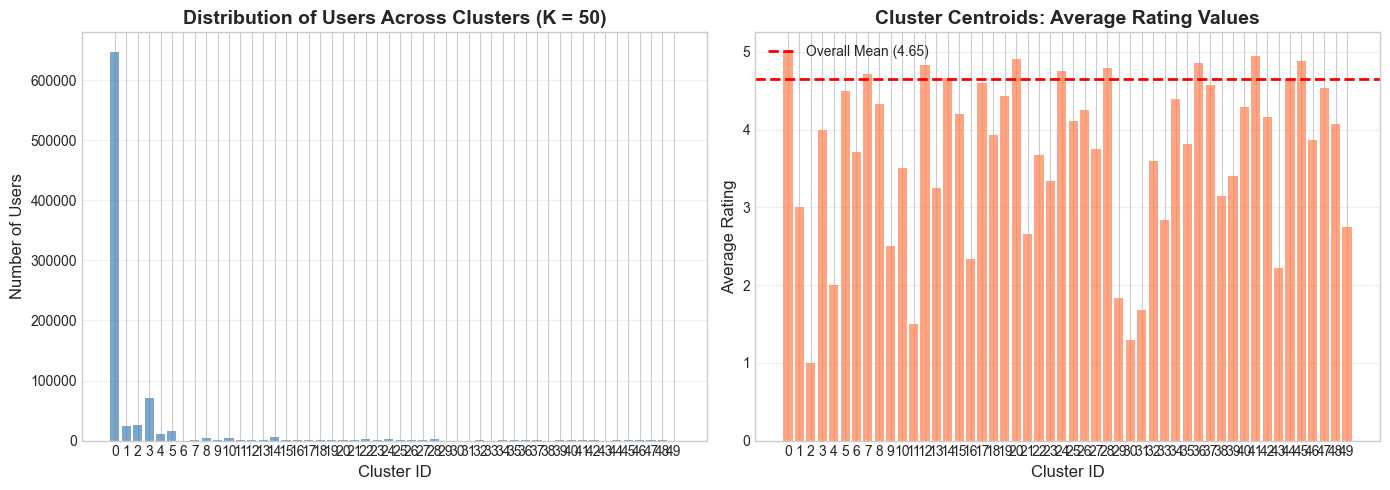

✓ Saved: part1_cluster_analysis.png


In [7]:
# =============================================================================
# ANALYZE OPTIMAL CLUSTERING
# =============================================================================
# Tasks 8.1-8.3: Distribution, centroids, generous vs strict raters

cluster_assignments = pd.DataFrame({
    'user_id': user_ids,
    'avg_rating': X.flatten(),
    'cluster': optimal_labels
})

# Distribution of users across clusters
cluster_distribution = cluster_assignments['cluster'].value_counts().sort_index()
print(f"Distribution of Users Across Clusters (K = {optimal_k}):")
print("=" * 60)
for cluster_id, count in cluster_distribution.items():
    percentage = (count / len(cluster_assignments)) * 100
    print(f"Cluster {cluster_id}: {count:,} users ({percentage:.2f}%)")

# Convert normalized centroids back to original scale
centroids_original_scale = optimal_centroids * sigma + mu
centroid_df = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Centroid_Avg_Rating': centroids_original_scale.flatten(),
    'Num_Users': cluster_distribution.values
}).sort_values('Centroid_Avg_Rating')

print(f"\nCluster Centroids (Average Rating Values):")
display(centroid_df)

# Identify generous vs strict raters
overall_mean = mu
generous_clusters = centroid_df[centroid_df['Centroid_Avg_Rating'] > overall_mean]['Cluster'].tolist()
strict_clusters = centroid_df[centroid_df['Centroid_Avg_Rating'] <= overall_mean]['Cluster'].tolist()

print(f"\nGenerous Raters (above mean {overall_mean:.2f}): Clusters {generous_clusters}")
print(f"Strict Raters (below/at mean {overall_mean:.2f}): Clusters {strict_clusters}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(range(optimal_k), cluster_distribution.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title(f'Distribution of Users Across Clusters (K = {optimal_k})', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(optimal_k))
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(optimal_k), centroids_original_scale.flatten(), color='coral', alpha=0.7)
axes[1].axhline(y=mu, color='red', linestyle='--', linewidth=2, label=f'Overall Mean ({mu:.2f})')
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].set_title(f'Cluster Centroids: Average Rating Values', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(optimal_k))
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'part1_cluster_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: part1_cluster_analysis.png")


In [8]:
# =============================================================================
# USER-BASED COLLABORATIVE FILTERING WITHIN CLUSTERS
# =============================================================================
# Tasks 9: Apply user-based CF within clusters for target users

# Target users and items from Section ONE
TARGET_USERS = {
    'U1': 'A10M98IRLT7VXA',
    'U2': 'A3STP1WNCC5KPK',
    'U3': 'A2T9FICTMRFR0J'
}
TARGET_ITEMS = {
    'I1': 'B00S33PD6W',
    'I2': 'B00DO4LN82'
}

# Helper functions
def mean_centered_cosine_similarity(user1_ratings, user2_ratings, common_items):
    """Calculate mean-centered cosine similarity."""
    if len(common_items) == 0:
        return 0.0
    r1 = np.array([user1_ratings[item] for item in common_items])
    r2 = np.array([user2_ratings[item] for item in common_items])
    mean1, mean2 = np.mean(r1), np.mean(r2)
    r1_centered, r2_centered = r1 - mean1, r2 - mean2
    dot_product = np.dot(r1_centered, r2_centered)
    norm1, norm2 = np.linalg.norm(r1_centered), np.linalg.norm(r2_centered)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

def predict_rating(target_user_id, target_item_id, similar_users, user_ratings_dict, user_avg_ratings_dict):
    """Predict rating using similar users."""
    target_avg = user_avg_ratings_dict.get(target_user_id, 0)
    numerator = sum(sim * (user_ratings_dict.get(suid, {}).get(target_item_id, 0) - user_avg_ratings_dict.get(suid, 0))
                    for suid, sim in similar_users if target_item_id in user_ratings_dict.get(suid, {}))
    denominator = sum(abs(sim) for _, sim in similar_users)
    if denominator == 0:
        return target_avg
    predicted = target_avg + (numerator / denominator)
    return max(1.0, min(5.0, predicted))

# Prepare data structures
user_ratings_dict = defaultdict(dict)
for _, row in ratings.iterrows():
    user_ratings_dict[row['user_id']][row['item_id']] = row['rating']
user_avg_ratings_dict = dict(zip(user_stats['user_id'], user_stats['avg_rating']))
user_to_cluster = dict(zip(user_ids, optimal_labels))

# Apply CF within clusters
clustering_predictions = {}
for target_name, target_user_id in TARGET_USERS.items():
    print(f"\n{'='*60}")
    print(f"Processing {target_name}: {target_user_id}")
    if target_user_id not in user_to_cluster:
        print(f"  Warning: User not found")
        continue
    
    target_cluster = user_to_cluster[target_user_id]
    cluster_users = [uid for uid, cid in user_to_cluster.items() if cid == target_cluster]
    print(f"  Cluster {target_cluster} ({len(cluster_users):,} users)")
    
    target_user_ratings = user_ratings_dict.get(target_user_id, {})
    similarities = []
    for other_user_id in cluster_users:
        if other_user_id == target_user_id:
            continue
        other_user_ratings = user_ratings_dict.get(other_user_id, {})
        common_items = set(target_user_ratings.keys()) & set(other_user_ratings.keys())
        if len(common_items) > 0:
            similarity = mean_centered_cosine_similarity(target_user_ratings, other_user_ratings, list(common_items))
            similarities.append((other_user_id, similarity))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_20_percent = max(1, int(len(similarities) * 0.20))
    top_similar_users = similarities[:top_20_percent]
    
    predictions = {}
    for target_item_name, target_item_id in TARGET_ITEMS.items():
        predicted_rating = predict_rating(target_user_id, target_item_id, top_similar_users,
                                         user_ratings_dict, user_avg_ratings_dict)
        predictions[target_item_name] = predicted_rating
        actual_rating = target_user_ratings.get(target_item_id, None)
        print(f"  {target_item_name}: Predicted={predicted_rating:.2f}, Actual={actual_rating if actual_rating else 'N/A'}")
    
    clustering_predictions[target_name] = predictions



Processing U1: A10M98IRLT7VXA
  Cluster 0 (647,508 users)
  I1: Predicted=5.00, Actual=N/A
  I2: Predicted=5.00, Actual=N/A

Processing U2: A3STP1WNCC5KPK
  Cluster 0 (647,508 users)
  I1: Predicted=5.00, Actual=N/A
  I2: Predicted=5.00, Actual=N/A

Processing U3: A2T9FICTMRFR0J
  Cluster 42 (578 users)
  I1: Predicted=4.14, Actual=N/A
  I2: Predicted=4.14, Actual=N/A


In [9]:
# =============================================================================
# COMPUTATIONAL EFFICIENCY ANALYSIS
# =============================================================================
# Tasks 11: Analyze efficiency gains

n_users = len(user_ids)
computations_without_clustering = n_users * (n_users - 1) // 2

cluster_sizes = cluster_distribution.values
computations_with_clustering = sum(size * (size - 1) // 2 for size in cluster_sizes)

speedup_factor = computations_without_clustering / computations_with_clustering if computations_with_clustering > 0 else 0
reduction_percentage = ((computations_without_clustering - computations_with_clustering) / computations_without_clustering) * 100

print("Computational Efficiency Analysis:")
print("=" * 60)
print(f"Total users: {n_users:,}")
print(f"\nWithout clustering:")
print(f"  Total user pairs: {computations_without_clustering:,}")
print(f"\nWith clustering (K = {optimal_k}):")
print(f"  Total user pairs (within clusters): {computations_with_clustering:,}")
print(f"\nEfficiency Gains:")
print(f"  Speedup Factor: {speedup_factor:.2f}x")
print(f"  Reduction in Computations: {reduction_percentage:.2f}%")
print(f"  Computations Saved: {computations_without_clustering - computations_with_clustering:,}")


Computational Efficiency Analysis:
Total users: 840,372

Without clustering:
  Total user pairs: 353,112,129,006

With clustering (K = 50):
  Total user pairs (within clusters): 213,075,012,526

Efficiency Gains:
  Speedup Factor: 1.66x
  Reduction in Computations: 39.66%
  Computations Saved: 140,037,116,480


## 10. Robustness Testing


In [10]:
# =============================================================================
# ROBUSTNESS TESTING
# =============================================================================
# Task 13: Test with different random initializations

from sklearn.metrics import adjusted_rand_score

print("Testing robustness with different random initializations...")
print("=" * 60)

n_runs = 3
random_states = [42, 123, 456]
all_cluster_assignments = []

sil_sample_size = 10000  # use same sample size as before for consistency
sil_random_state = 42

for run_idx, random_state in enumerate(random_states, 1):
    print(f"\nRun {run_idx} (random_state={random_state}):")
    kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_normalized)
    all_cluster_assignments.append(labels)
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print(f"  Cluster sizes: {dict(cluster_counts)}")
    silhouette = silhouette_score(
        X_normalized,
        labels,
        sample_size=min(sil_sample_size, len(X_normalized)),
        random_state=sil_random_state
    )
    print(f"  WCSS: {kmeans.inertia_:.2f}, Silhouette: {silhouette:.4f}")

# Compare cluster assignments
agreement_scores = []
for i in range(len(all_cluster_assignments)):
    for j in range(i + 1, len(all_cluster_assignments)):
        ari = adjusted_rand_score(all_cluster_assignments[i], all_cluster_assignments[j])
        agreement_scores.append(ari)
        print(f"  Run {i+1} vs Run {j+1}: ARI = {ari:.4f}")

avg_agreement = np.mean(agreement_scores)
print(f"\nAverage agreement (ARI): {avg_agreement:.4f}")
if avg_agreement > 0.9:
    print("  ✓ Clustering is STABLE")
elif avg_agreement > 0.7:
    print("  ⚠ Clustering is MODERATELY STABLE")
else:
    print("  ✗ Clustering is UNSTABLE")


Testing robustness with different random initializations...

Run 1 (random_state=42):
  Cluster sizes: {0: np.int64(647508), 1: np.int64(24966), 2: np.int64(25432), 3: np.int64(71483), 4: np.int64(11734), 5: np.int64(15777), 6: np.int64(112), 7: np.int64(1049), 8: np.int64(4607), 9: np.int64(839), 10: np.int64(3735), 11: np.int64(249), 12: np.int64(1414), 13: np.int64(306), 14: np.int64(6496), 15: np.int64(1094), 16: np.int64(374), 17: np.int64(1556), 18: np.int64(165), 19: np.int64(831), 20: np.int64(855), 21: np.int64(242), 22: np.int64(2180), 23: np.int64(704), 24: np.int64(3397), 25: np.int64(355), 26: np.int64(1497), 27: np.int64(594), 28: np.int64(2383), 29: np.int64(30), 30: np.int64(45), 31: np.int64(69), 32: np.int64(322), 33: np.int64(66), 34: np.int64(1219), 35: np.int64(514), 36: np.int64(982), 37: np.int64(728), 38: np.int64(104), 39: np.int64(237), 40: np.int64(444), 41: np.int64(671), 42: np.int64(578), 43: np.int64(63), 44: np.int64(555), 45: np.int64(1025), 46: np.int6